In [1]:
!pip install networkx==2.5
!pip install more_itertools==8.6.0
!pip install nltk==3.5
!pip install fa2==0.3.5
!pip install wordcloud==1.8.1

In [2]:
import urllib.request
import json
import pandas as pd
import re
import io
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import more_itertools
import math

from nltk.corpus import PlaintextCorpusReader, stopwords
from pandas.core.common import flatten
from networkx.readwrite import json_graph
from collections import defaultdict
from fa2 import ForceAtlas2
from scipy.stats import pearsonr
from collections import defaultdict
from wordcloud import WordCloud

try:
    import nltk
except:
    !pip install nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# The Human Body

## 1. Motivation

The objective for this project is to get a closer look at the words describing the human body through anatomical pages on Wikipedia.

The dataset was manually created using inspiration from a [Wikipedia page](https://en.wikipedia.org/wiki/List_of_organs_of_the_human_body)
and the result was [this dataset](https://github.com/noramurakozy/noramurakozy.github.io/blob/main/data/anatomy.csv).

By making the dataset manually, there are most likely missing body parts that would have contributed to a different end-result,
but it was estimated to be the best way to do it for this project, and the results should still be interesting.

The hope is to learn more about how Wikipedia uses references to different pages describing human anatomy.
As these references are written by humans, they could potentially be the wild west, or perhaps they make a lot of sense.
For this, the network analysis will be useful.

A favorable outcome is also to learn more about the common words used in the medical world to describe our body.
For that, comparing the words on Wikipedia to an anatomical textbook makes sense,
so that it an be determined whether or not the words on Wikipedia reflect anatomical accuracy.
Here, text analysis will be useful.

## 2. Basic stats

In this section, everything related to the data, extracting the data from Wikipedia and preparing the data for analysis can be found.

### Functions

A couple of functions have been defined for this section to repeat and also make it easier to read later on.

The first function extracts Wikipedia pages using a pandas data frame, like it was done in the previous assignment, using the WikiMedia api, and then saving the text to txt-files.

The second function opens the pages containing content text from Wikipedia to find the links to other pages in the data frame. The result is a dictionary that will make it easy to create the network.

Below are the function used for this section.

In [3]:
# Input: a pandas data frame containing the names and links of Wikipedia pages,
# a directory as string, where the extracted Wikipedia pages should be put,
# and a string of the content type to extract in Wikipedia
# Result: txt-files containing the content type for each row in the pandas data frame
def download_pages(df: pd.DataFrame, folder: str, content_query: str):
    if not os.path.exists(folder):
        try:
            os.makedirs(folder)
        except OSError:
            print("Could not find or create directory.")
            return
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    dataformat ="format=json"
    for row in df.itertuples():  
        title = "titles=" + urllib.parse.quote(row.WikiLink)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content_query, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')
        wiki_json = json.loads(wikitext)

        for key in wiki_json["query"]["pages"]:
            if key == -1:
                print("Does not exists: " + row.WikiLink)
            try:
                content_to_save = wiki_json["query"]["pages"][key]["revisions"][0]["*"]
            except:
                content_to_save = wiki_json['query']['pages'][key]['extract']
            if not pd.isnull(row.WikiSection):
                content_to_save = re.findall('(?s)={3} ?'+row.WikiSection+'.*? ?={3}(.*?)(?:[^=]={2,3} ?.+? ?={2,3}|$)|={2} ?'+row.WikiSection+' ?={2}(.*?)(?:[^=]={2} ?.+? ?={2}|$)', content_to_save)
                content_to_save = ''.join(content_to_save[0]).strip() if content_to_save else ""
        
        f = io.open(folder + "/" + row.Name + '.txt','w+',encoding='utf-8')
        f.write(content_to_save)
        f.close()

In [4]:
# Input: a pandas data frame, a directory containing txt-files with 'revisions' extraction from Wikipedia
# Output: a dictionary containing the WikiLinks as keys, and its references as items
def clean_links(df: pd.DataFrame, folder: str):
    link_dict = {}
    for row in df.itertuples():
        link_dict[row.WikiLink] = []
        content = io.open(folder + "/" + f'{row.Name}.txt', 'r', encoding='utf-8').read()
        #links = re.findall(r'\[\[([^|^\]]+)\|?[^\]]*\]\]', content)
        references = re.findall(r'\[\[(.*?)\]\]', content)
        for reference in references:
            for link in reference.split('|'):
                link = link.capitalize()
                if len(df[df['WikiLink'] == link]) and link not in link_dict[row.WikiLink] and row.WikiLink != link:
                    link_dict[row.WikiLink].append(link)
    return link_dict

### Overview of the data

The data is contained in a csv-file, so let's start by putting it into a pandas data frame for an easy overview.

In [5]:
df = pd.read_csv('./anatomy.csv' ,sep = '|')

The first and last lines of data can be checked using pandas included head and tail functions. From using these, it can be seen that the data file includes 1134 lines of data, along with 4 attributes.

'Name' is the name of the organ (with clarification if necessary).

'System' is the bodily system that the organ is part of. There 9 of these, and will be explained further later.

'WikiLink' is the link that is included in the URL when looking at the given page on Wikipedia.

'WikiSection' is the section on Wikipedia that needs to be extracted, if only a portion of the page is relevant to extract.

In [6]:
df.head()

Name           System            WikiLink WikiSection
0  Cervical vertebrae  Muscular system  Cervical vertebrae         NaN
1  Thoracic vertebrae  Muscular system  Thoracic vertebrae         NaN
2    Lumbar vertebrae  Muscular system    Lumbar vertebrae         NaN
3              Sacrum  Muscular system              Sacrum         NaN
4              Coccyx  Muscular system              Coccyx         NaN

In [7]:
df.tail()

Name              System            WikiLink WikiSection
1129              Larynx  Respiratory system              Larynx         NaN
1130             Trachea  Respiratory system             Trachea         NaN
1131            Bronchus  Respiratory system            Bronchus         NaN
1132                Lung  Respiratory system                Lung         NaN
1133  Thoracic diaphragm  Respiratory system  Thoracic diaphragm         NaN

### Extracting Wikipedia page text

Let's download the Wikipedia pages with revisions and redirects for the creation of the network, and the explain text for a clean version of the text for later text analysis.

In [8]:
download_pages(df, "./WikipediaPage/Content", "prop=revisions|redirects&rvprop=content")
download_pages(df, "./WikipediaPage/Explain", "prop=extracts&explaintext")

The content and explain text has now been saved, and can be seen to be different. The content text includes references to other Wikipedia pages as an example, e.g. \[\[calvaria (skull)|calvaria]], \[\[mandible]]. The explain text is the clean text that you can read on Wikipedia.

In [9]:
f = io.open('./WikipediaPage/Content/Cranial bones.txt','r',encoding='utf-8')
print(f.read()[-250:])

nes]] form the [[calvaria (skull)|calvaria]] (skullcap). The membranous viscerocranium includes the [[mandible]].

The sutures are fairly rigid joints between bones of the neurocranium.

The facial skeleton is formed by the bones supporting the face.


In [10]:
f = io.open('./WikipediaPage/Explain/Cranial bones.txt','r',encoding='utf-8')
print(f.read()[-250:])

upper areas of the cranial bones form the calvaria (skullcap). The membranous viscerocranium includes the mandible.
The sutures are fairly rigid joints between bones of the neurocranium.
The facial skeleton is formed by the bones supporting the face.


Let's create a dictionary containing all the Wikipedia links and the pages they reference.

In [11]:
node_link_dict = clean_links(df, "./WikipediaPage/Content/")

Picking the name of any organ in the data, its references to other Wikipedia pages can now be found.

In [12]:
print(node_link_dict["Cervical vertebrae"])

['Skull', 'Thoracic vertebrae', 'Lumbar vertebrae', 'Cervical rib', 'Vertebral artery', 'Inferior cervical ganglion', 'Trapezius', 'Splenius capitis muscle', 'Joint', 'Vertebral vein', 'Vein', 'Spinal nerve', 'Brachial plexus', 'Cervical plexus', 'Subclavian artery', 'Subclavian vein', 'Occipital bone', 'Thoracic diaphragm', 'Mandible', 'Hyoid bone', 'Common carotid artery', 'Esophagus', 'Larynx', 'Trachea']


## 3. Tools, theory and analysis

The next sections will involve the different types of analysis. The sections are **Network** and **Text analysis**, and have subsections that are describing and doing a certain analysis.

In the **Network** section, the network is created and some basic stats are being looked at. Moving on from there, we will look at the connectivity (degree distribution) of the network, for a better understanding of the network before drawing it. Then, centrality is used to see which nodes are the most impactful on the network. At last, communities are created to better understand which nodes have high connectivities inbetween. The community extraction will also be important for the next part.

In the **Text analysis** section, a deeper look is made on the words used on Wikipedia to try and better understand these pages are written. This is further underlined by comparing the Wikipedia pages about anatomy to an anatomical textbook, where it is then expected to be able to make a conclusion on how medically accurate Wikipedia is.<br>
Last, word clouds are created for Wikipedia and the textbook, both for common words, but also using TF-IDF to find unique words between the texts. This hopefully also contributes to how medically accurate the text on Wikipedia is. Word clouds using TF-IDF to find unique words between the communities and systems are also made to see how common these pages that are referencing each other are.<br>
Sentiment analysis was also added for a look into how sentimental the words used in Wikipedia are, but it is not expected to have a big impact on the overall analysis.

## Network

This section will go through the creation of the network, look at some of its basic features, draw it, and look at some further details.

### Creating the network

Let's start by creating an empty directed graph.

In [13]:
G = nx.DiGraph()

Now using the dictionary containing the name of the Wikipedia links and the Wikipedia pages that they link to, nodes and edges can be added to the graph, where a link from one page to another is a directed edge from one node to another.

In [14]:
G.add_nodes_from(node_link_dict.keys())
for key in node_link_dict.keys():
    for value in node_link_dict[key]:
        if value not in node_link_dict.keys():
            print(value)
        G.add_edge(key, value) 

Let's check how many connected components are exists in the network, as we want to ensure that we are working with the largest connected component.

In [15]:
components = list(nx.connected_components(G.to_undirected()))
print(f'The number of components in the network are: {len(components)}')

The number of components in the network are: 1


This means that it is not necessary to extract the GCC as all the nodes in the network are already connected.

Let's see what our graph looks like.

In [16]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 1131
Number of edges: 8934
Average in degree:   7.8992
Average out degree:   7.8992


There are about double the amount of edges compared to nodes, and the average node node has about 8 connections.

Now that the network is looking good, let's add some attributes to the nodes: the system attribute from data set, and the amount of words on the pages.

In [17]:
for node in G.nodes:
    filename = df[df.WikiLink == node].Name.values[0]
    file_content = io.open(f"./WikipediaPage/Explain/{filename}.txt", 'r', encoding='utf-8').read()
    G.nodes[node]['Content length'] = len(re.findall(r'\w+', file_content))
    G.nodes[node]["System"] = df[df.WikiLink == node]["System"].values[0]
    
a = nx.get_node_attributes(G,'System')
print(np.unique([x[1] for x in a.items()]))

['Circulatory system' 'Digestive system' 'Endocrine system'
 'Integumentary system' 'Muscular system' 'Nervous system'
 'Reproductive organs' 'Respiratory system' 'Urinary system']


The network can be quickly be saved, and loaded back up for later.

In [18]:
# save graph to file
data = json_graph.node_link_data(G)
s = json.dumps(data)
with open("./Human_Body_Graph.json", 'w') as f:
    json.dump(s, f)

In [19]:
# load graph from file
graph_data_raw = io.open("./Human_Body_Graph.json", 'r', encoding='utf-8').read()
data = json.loads(graph_data_raw)
data_json = json.loads(data)
FROM_FILE = json_graph.node_link_graph(data_json)

In [20]:
print(len(FROM_FILE.nodes))
print(len(FROM_FILE.edges))

1131
8934


### Connectivity

As this is a directed graph, we can easily check the most connected nodes, and the connections coming in and going out of each node.

Let's also check the nodes with the most degrees in general (using an undirected version of the network).

In [21]:
top_5_connected_node = sorted([(n, d) for n, d in G.to_undirected().degree()], key=lambda x: x[1], reverse=True)[:5]
for i, (name, degrees) in enumerate(top_5_connected_node):
    print(f'{i+1}.\t{name} with {degrees} degrees')

1.	Artery with 106 degrees
2.	Human brain with 83 degrees
3.	Pelvis with 82 degrees
4.	Facial nerve with 81 degrees
5.	Vein with 74 degrees



The most connected node in our network is the *Artery*, which plays an important role in the human body, because it's a blood vessel that takes blood away from the heart to one or more parts of the body, so it makes sense that this is the most referred node in the system. 
The second is the *Human brain*, which we expected to have among the most connected nodes. 
The third is the *Pelvis*, most probably because we have a lot vital organs in the pelvis area. 
The last 2 is the *Facial nerve* and the *Vein*, which play a very important role in our body as well.

In [22]:
top_5_connected_degree_out = sorted([(n, d) for n, d in G.out_degree()], key=lambda x: x[1], reverse=True)[:5]
print('The pages with most references to other anatomy pages:')
for i, (name, degrees) in enumerate(top_5_connected_degree_out):
    print(f'{i+1}.\t{name} with {degrees} degrees')

The pages with most references to other anatomy pages:
1.	Human brain with 75 degrees
2.	Sacral plexus with 61 degrees
3.	Cranial nerves with 51 degrees
4.	Hand with 44 degrees
5.	Pelvis with 42 degrees


All of these nodes have a reason to be in this list.
The node called *Human brain* has the most links to other organs, it's because our brain sends the signals to start a reaction processes in our body, so it's natural that it refert to many other nodes in the network. 
The second is the *Sacral plexus*, which is a nerve plexus which provides motor and sensory nerves for the posterior thigh, most of the lower leg and foot, and part of the pelvis. 
The *Cranial nerves* are the nerves that emerge directly from the brain and relay information between the brain and parts of the body, primarily to and from regions of the head and neck, including the special senses of vision, taste, smell, and hearing.
Our *Hand* also refers to a lot of body parts and organs, because it's full of nerves and bones and it's part of our upper limb.
*Pelvis* is also among the most connected nodes and it's also part of the above list, because it contains and refers to the most vital organs and nerves that are located here.

In [23]:
top_5_connected_degree_in = sorted([(n, d) for n, d in G.in_degree()], key=lambda x: x[1], reverse=True)[:5]
print('The pages with most references from other anatomy pages:')
for i, (name, degrees) in enumerate(top_5_connected_degree_in):
    print(f'{i+1}.\t{name} with {degrees} degrees')

The pages with most references from other anatomy pages:
1.	Artery with 101 degrees
2.	Facial nerve with 76 degrees
3.	Vein with 64 degrees
4.	Vagus nerve with 61 degrees
5.	Pelvis with 57 degrees


*Artery* is the most connected node in our system and we can see that it has also the highest in-degree. It means 101 anatomny pages refer to the Artery page, which makes sense, because arteries are directly connected with our most important organ: the heart.
The *Facial nerve* is the seventh cranial nerve and it emerges from the pons of the brainstem, controls the muscles of facial expression and other functions in that area, so all these organs and body parts refers to this page which are related to the mentioned functions.
The *Vein* also got a place in this list, because they are blood vessels that carry blood towards the heart, so many nodes have reference to it.
The *Vagus nerve* is the tenth cranial nerve and interfaces with the parasympathetic control of the heart, lungs, and digestive tract, so probably it has a high in-degree count because it is realted to
vital functions and organs like heart, lungs and the digestive system.
The *Pelvis* area is also reffered many times on other pages because it contains our vital organs and nerves.

*Conclusion:*
To conclude the above findings, looking at the pages with most out degree, the human brain, hand and pelvis are all well known organs, with quite a few things going on, while sacral plexus contains a list of nerves, and cranial nerves talks about a lot of nerves.

Looking at the pages with most in degree, it is no surprise that artery, vein and nerves are listed, as they are essential in many parts of the body. And, again, the pelvis area has a lot going on around it.

Now, let's take a look at the over degree distribution.

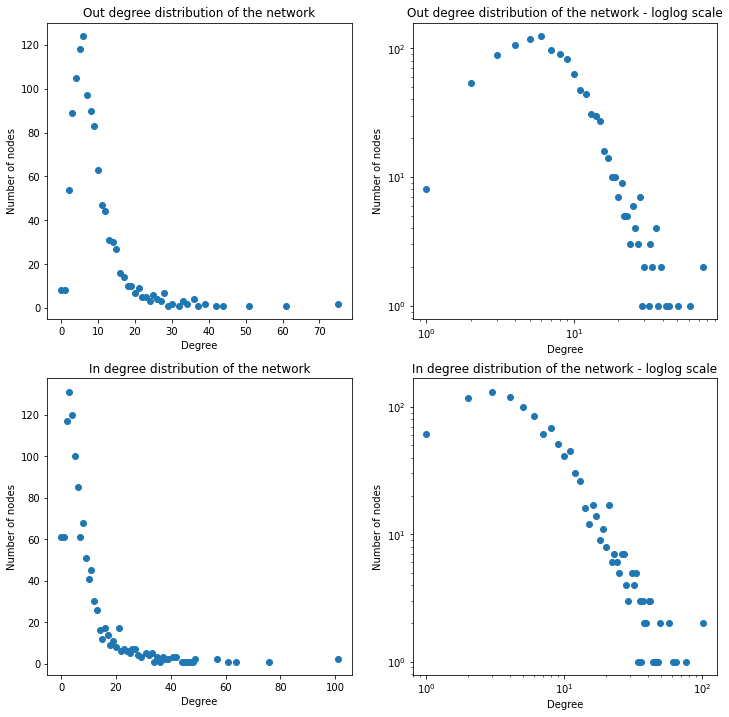

In [24]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 12)

out_degrees = [d for n, d in G.out_degree()]
bins_out = np.unique(out_degrees)
x, bin_edges = np.histogram(out_degrees, bins=bins_out)
plt.subplot(221)
plt.title("Out degree distribution of the network")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.plot(bin_edges, np.insert(x, 0, x[0]), linestyle="",marker="o")

plt.subplot(222)
plt.title("Out degree distribution of the network - loglog scale")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.loglog(bin_edges, np.insert(x, 0, x[0]), linestyle="",marker="o")

in_degrees = [d for n, d in G.in_degree()]
bins_in = np.unique(in_degrees)
x, bin_edges = np.histogram(in_degrees, bins=bins_in)
plt.subplot(223)
plt.title("In degree distribution of the network")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.plot(bin_edges, np.insert(x, 0, x[0]), linestyle="",marker="o")

plt.subplot(224)
plt.title("In degree distribution of the network - loglog scale")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.loglog(bin_edges, np.insert(x, 0, x[0]), linestyle="",marker="o")

plt.show()

Interestingly, there are only a few nodes with no or few references to other pages, where it seems to be common to have around eight references to other pages, with some pages having even more references.

It is more common for pages not to be refered to, which makes sense, but it is still more common to receive (what looks like) 5 references from other pages, which is quite a lot for the average page.

As a mean of further investigation, the created network distribution can be compared to that of a random network with the same number of nodes and connectivity.

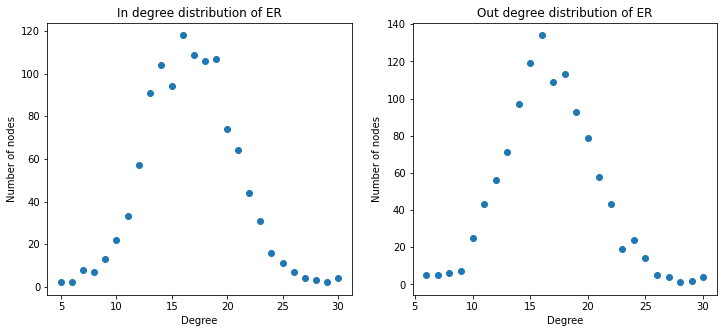

In [25]:
# Calculate p and create a random network with the given parameters
degrees = [d for n, d in G.degree()]
k = np.mean(degrees)
p = k/(len(G.nodes)-1)
ER = nx.erdos_renyi_graph(len(G.nodes), p, directed=True)

# Plot degree distribution of the Erdos-Renyi network
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

in_degrees_ER = [d for n, d in ER.in_degree()]
bins_in = np.unique(in_degrees_ER)
x, bin_edges_ER = np.histogram(in_degrees_ER, bins=bins_in)

plt.subplot(121)
plt.title("In degree distribution of ER")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.plot(bin_edges_ER, np.insert(x, 0, x[0]), linestyle="",marker="o")

out_degrees_ER = [d for n, d in ER.out_degree()]
bins_out = np.unique(out_degrees_ER)
x, bin_edges_ER = np.histogram(out_degrees_ER, bins=bins_out)
plt.subplot(122)
plt.title("Out degree distribution of ER")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.plot(bin_edges_ER, np.insert(x, 0, x[0]), linestyle="",marker="o")

plt.show()

The above figure clearly shows that the degrees of a random network (ER) follow a Poisson distribution, therefore most nodes have comparable degrees and nodes with a large number of links are missing. While in a network with a power-law degree distribution, most nodes have only a few links. These numerous small nodes are held together by a few highly connected hubs.

### Drawing the network

Now that we know about the network, let's visualize it to get a better idea of what is going. For this, the graph is made undirected for this, so it is easier to work with.

In [26]:
GU = G.to_undirected()

Let's start by simply visualizing the network using the ForceAtlas2 algorithm.

In [27]:
# setup ForceAtlas2
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1,
                          # Log
                          verbose=True) 

# Calculate positions with the algorithm
positions = forceatlas2.forceatlas2_networkx_layout(GU, pos=None, iterations=200) 

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.26it/s]

BarnesHut Approximation  took  2.97  seconds
Repulsion forces  took  27.39  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.18  seconds
AdjustSpeedAndApplyForces step  took  0.34  seconds


Now, a simple representation of the network can be drawn.

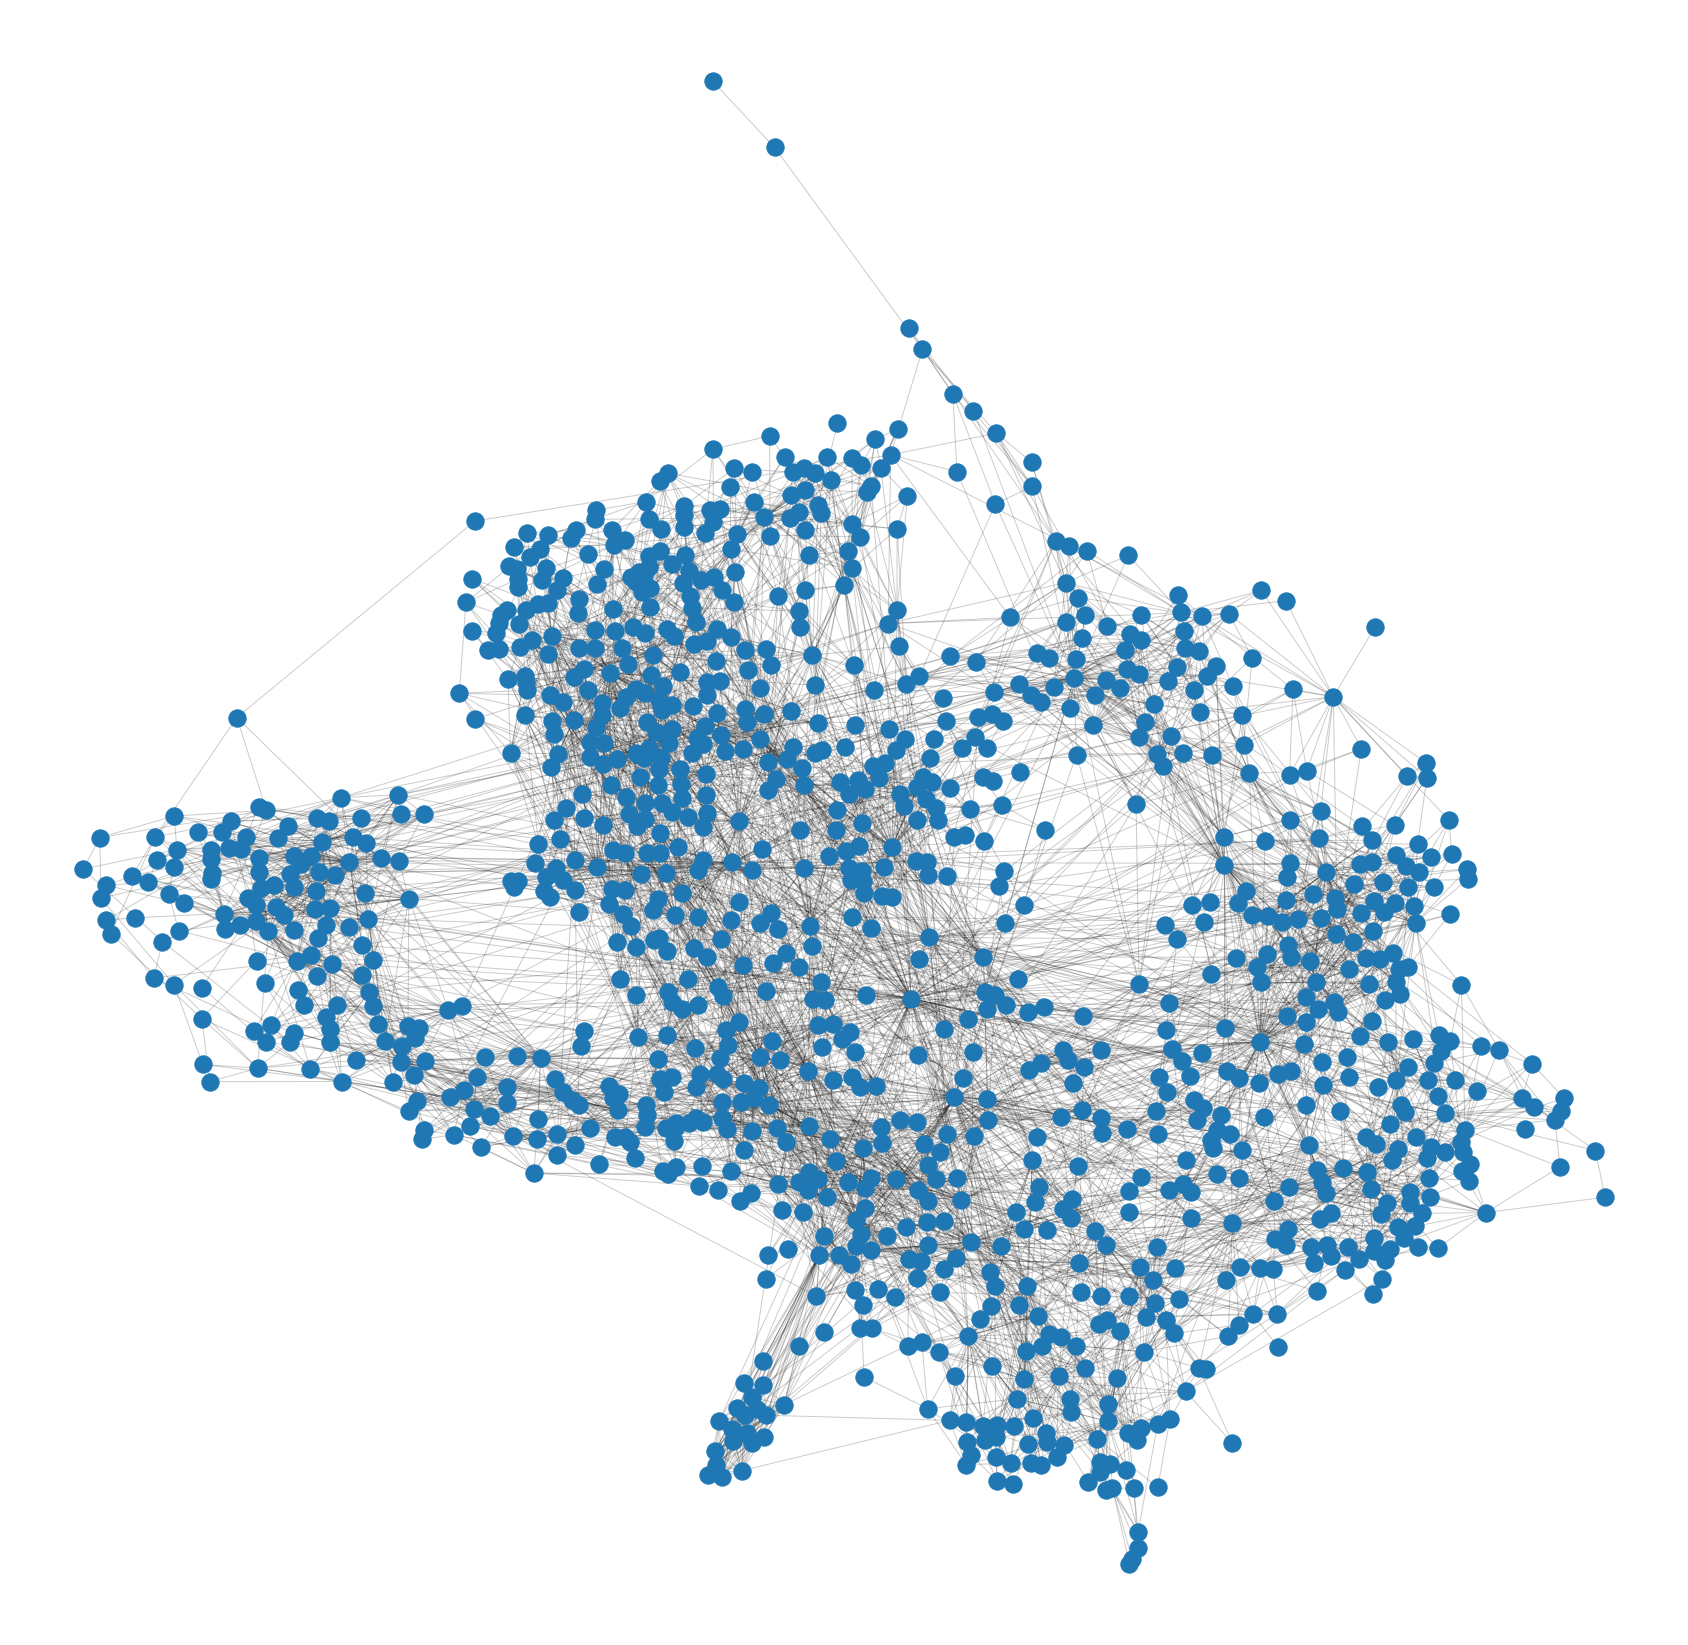

In [28]:
# Draw the network with the previously calculated positions
# Node size is propotional to its degree
# Node color changes according to universe
# Edge color changes according to its start- and end-universe
f = plt.figure()
f.set_size_inches(30, 30)
nx.draw_networkx_edges(GU, positions, alpha=0.2)
nx.draw_networkx_nodes(GU, positions, alpha=1)
plt.axis('off')
plt.show()

To improve understanding, the nodes in the network are colored to represent the system that they belong to.

In [29]:
# Visualize the network
color_map=[]
edge_color_map = []

# Create node color map based on the organ's system
# red: muscular, blue: digestive, green: respiratory, 
# brown: urinary, orange: reproductive, yellow: endocrine
# purple: circulatory, pink: nervous, cyan: integumentary
for node in GU.nodes:
    if GU.nodes[node]['System'] == "Muscular system":
        color_map.append("#FF0000")
    elif GU.nodes[node]['System'] == "Digestive system": 
        color_map.append("#0000FF")
    elif GU.nodes[node]['System'] == "Respiratory system": 
        color_map.append("#8bc34a")
    elif GU.nodes[node]['System'] == "Urinary system": 
        color_map.append("#b23c17")        
    elif GU.nodes[node]['System'] == "Reproductive organs": 
        color_map.append("#ff9800")
    elif GU.nodes[node]['System'] == "Endocrine system": 
        color_map.append("#ffeb3b")            
    elif GU.nodes[node]['System'] == "Circulatory system": 
        color_map.append("#9c27b0")           
    elif GU.nodes[node]['System'] == "Nervous system": 
        color_map.append("#e91e63")  
    elif GU.nodes[node]['System'] == "Integumentary system": 
        color_map.append("black")                                
    else:
        color_map.append("white")

With the node positions calculated, the network can be drawn. The nodes and edges are made more transparent, and nodes are scaled according to number of degrees to highlight the most important nodes for the network.

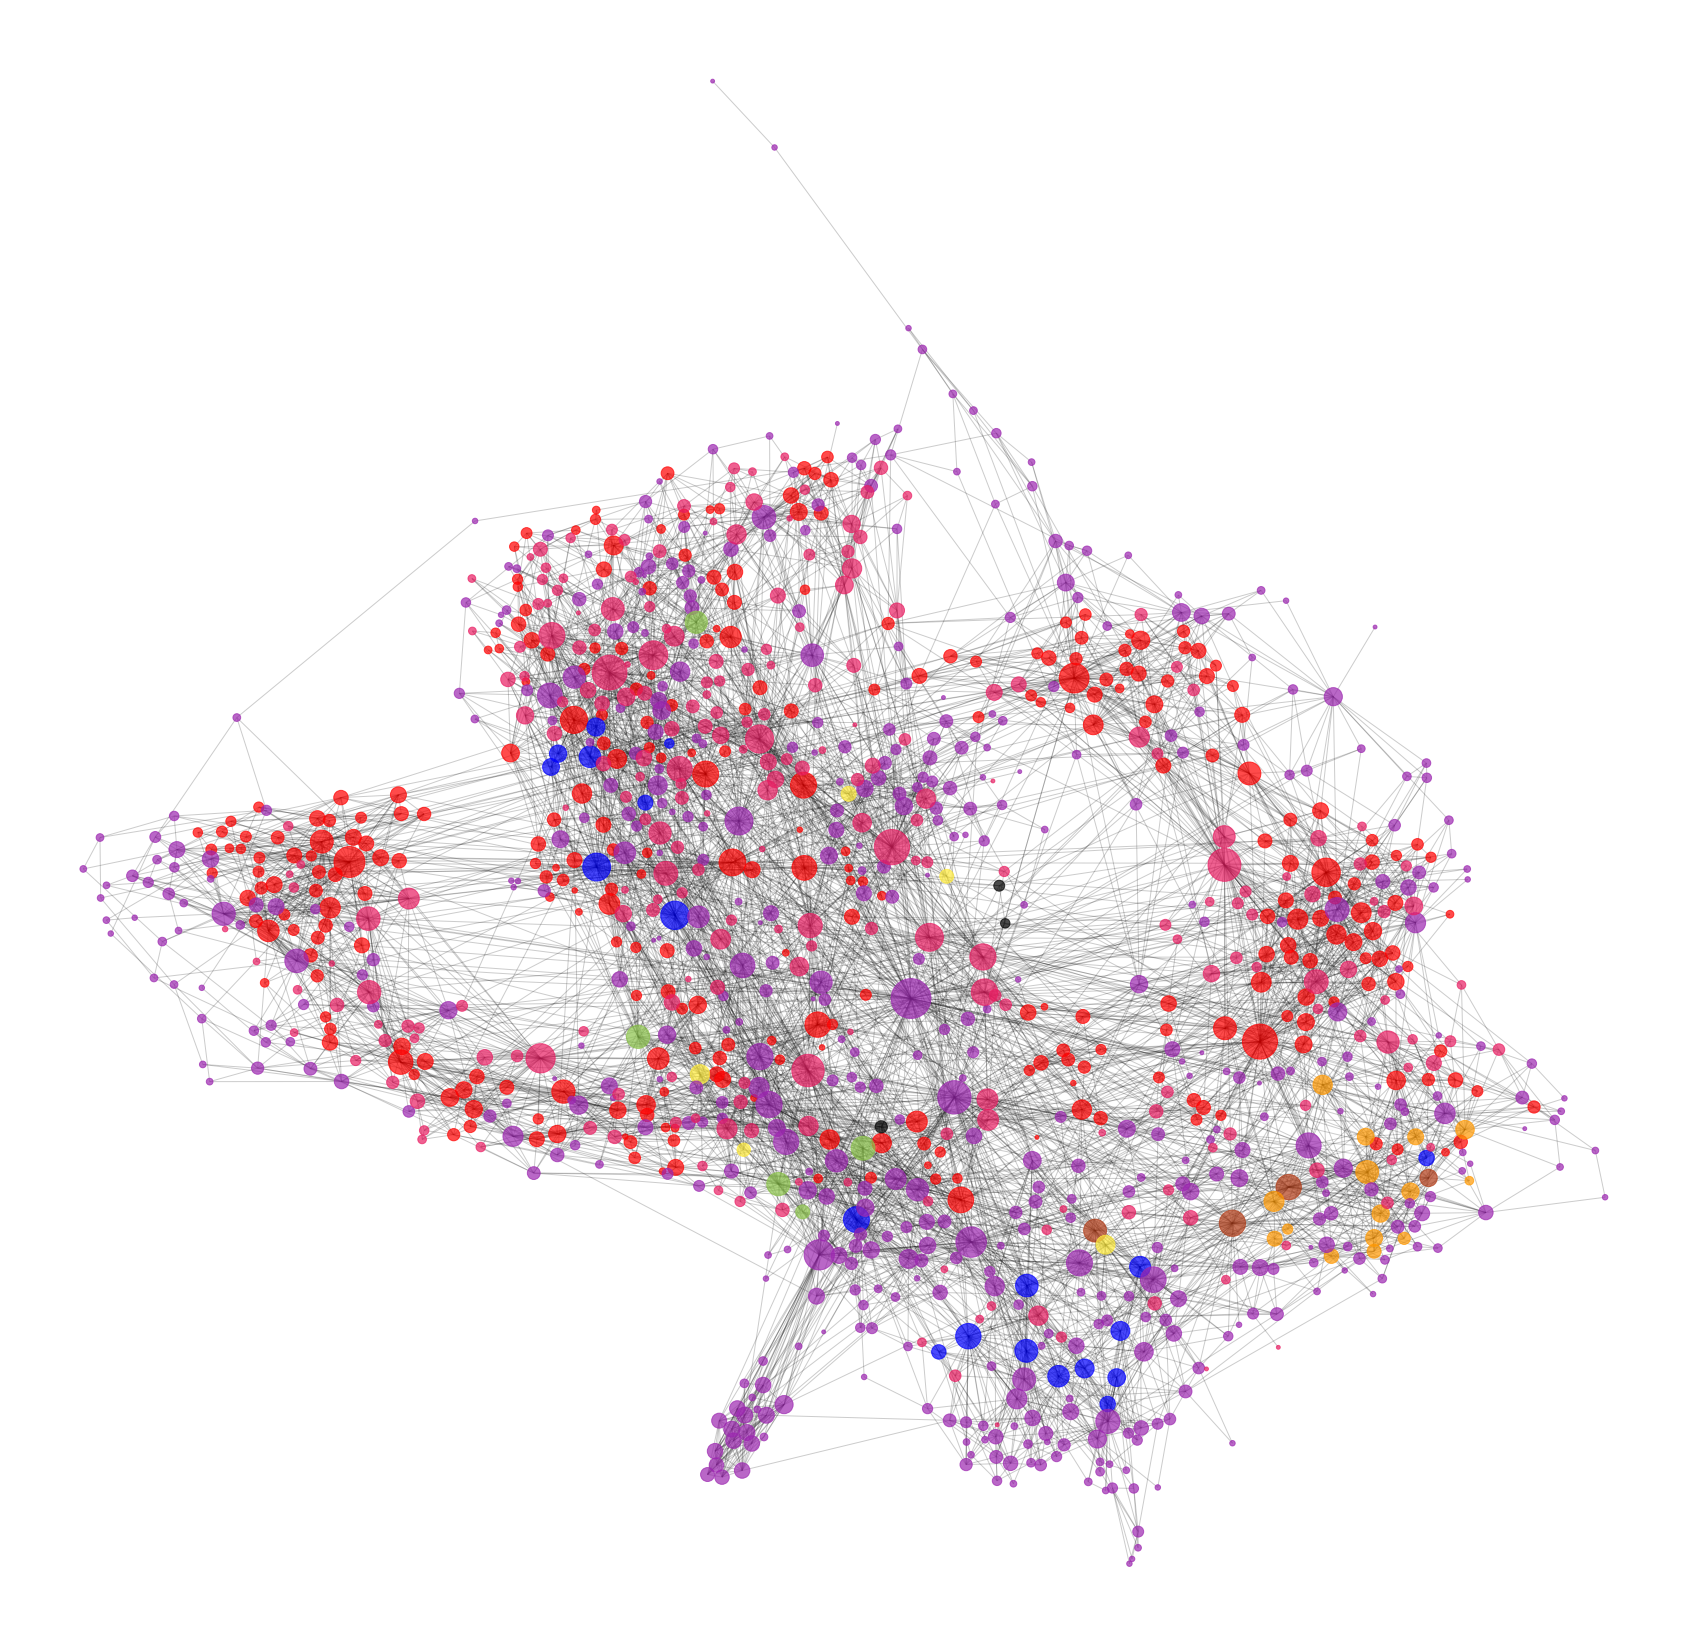

In [30]:
# Draw the network with the previously calculated positions
# Node size is propotional to its degree
# Node color changes according to universe
# Edge color changes according to its start- and end-universe
f = plt.figure()
f.set_size_inches(30, 30)
nx.draw_networkx_edges(GU, positions, alpha=0.2)
nx.draw_networkx_nodes(GU, positions, node_size=[d*15 for n, d in GU.degree], node_color=color_map, alpha=0.7)
plt.axis('off')
plt.show()

The network has now been drawn with all its nodes and edges.
The nodes are colored depending on which system that it belongs to.
For now, it can be concluded that the nodes are not particularly connected in their defined systems,
and it can be seen that the colors red (muscular), purple (circulatory) and pink (nervous) are quite widespread.
This could be an indication that the nodes are in fact linked according to placement in the body, which would also make sense.

### Centrality


Now we will start studying the centrality in our network to identify the most important 
nodes within our graph depeding on the different parameters.

**Degree centrality**

Degree centrality assigns an importance score based simply on the number of links held by each node. It tells us how many direct, ‘one hop’ connections each node has to other nodes in the network.

In [31]:
# sort dictionary by value ({node: centrality value})
sorted_centralities = {k: v for k, v in sorted(nx.degree_centrality(G).items(), key=lambda item: item[1], reverse=True)}
most_centralized_5 = more_itertools.take(5, sorted_centralities.items())
for i, (name, centrality) in enumerate(most_centralized_5):
    print(f'{i+1}.\t{name} with {centrality:.4f} degree centrality')

1.	Artery with 0.1000 degree centrality
2.	Facial nerve with 0.0929 degree centrality
3.	Pelvis with 0.0876 degree centrality
4.	Human brain with 0.0832 degree centrality
5.	Vagus nerve with 0.0805 degree centrality


The 5 most centralized nodes are the *Artery* (which is also the most connected), the *Facial nerve*, *Pelvis*, *Human brain* (these are all part of the list of top 5 connected nodes). In addition we have the *Vagus nerve*, which is " ... the tenth cranial nerve or CN X, and interfaces with the parasympathetic control of the heart, lungs, and digestive tract...". The results make sense because all these body parts have an important role and connected with many other parts in our body.

**Betweenness centrality**

Betweenness centrality measures the number of times a node lies on the shortest path between other nodes. This measure shows which nodes are ‘bridges’ between nodes in a network. It does this by identifying all the shortest paths and then counting how many times each node falls on one.

In [32]:
# sort dictionary by value (node: betweenness value)
sorted_centralities_b = {k: v for k, v in sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse=True)}
most_betweenness_centralized_5 = more_itertools.take(5, sorted_centralities_b.items())
for i, (name, centrality) in enumerate(most_betweenness_centralized_5):
    print(f'{i+1}.\t{name} with {centrality:.4f} betweenness centrality')

1.	Vein with 0.0876 betweenness centrality
2.	Artery with 0.0758 betweenness centrality
3.	Human brain with 0.0745 betweenness centrality
4.	Hand with 0.0619 betweenness centrality
5.	Spinal nerve with 0.0573 betweenness centrality


The first 2 most centralized node in terms of betweenness are the *Vein* and the *Artery*, which is a very interesting fact because our vein network works as a delivery system in our body, so it makes that in our network the organs are connected through the veins, it reflects the real life. The next is the *Human brain* and we know that our organs communicates with our brain with signals and hormones in order to get a response to start a reaction process in our body in the same organ or in other parts of the body.
The fourth is the *Hand* which is full of nerves, bones and cartilages. *Spinal nerve* is the fifth most centralized and is a mixed nerve, which carries motor, sensory, and autonomic signals between the spinal cord and the body.

**Eigenvector centrality**

Like degree centrality, eigenvector centrality measures a node’s influence based on the number of links it has to other nodes in the network. Eigenvector centrality then goes a step further by also taking into account how well connected a node is, and how many links their connections have, and so on through the network. By calculating the extended connections of a node, eigenvector centrality can identify nodes with influence over the whole network, not just those directly connected to it.

In [33]:
# For directed graphs this is “left” eigenvector centrality which corresponds to the in-edges in the graph. 
# sort dictionary by value (node: eigenvector_centrality value)
sorted_centralities_e_in = {k: v for k, v in sorted(nx.eigenvector_centrality(G).items(), key=lambda item: item[1], reverse=True)}
most_eigen_centralized_5_in = more_itertools.take(5, sorted_centralities_e_in.items())
for i, (name, centrality) in enumerate(most_eigen_centralized_5_in):
    print(f'{i+1}.\t{name} with {centrality:.4f} eigenvector centrality')

1.	Vagus nerve with 0.2485 eigenvector centrality
2.	Heart with 0.1947 eigenvector centrality
3.	Artery with 0.1740 eigenvector centrality
4.	Aorta with 0.1714 eigenvector centrality
5.	Trachea with 0.1590 eigenvector centrality


The most central node is *Vagus nerve* and "... interfaces with the parasympathetic control of the heart, lungs, and digestive tract." This means that this nerve - since it plays a higly important role - has neighbors which are also highly connected similarly to itself.
*Heart* is our most important organ, so it makes sense to have it among these nodes and it's true that it's connected to nodes also with high importance.
*Artery* and *Aorta* are also connected to highly connected nodes, which makes sense, they are essential parts of the circulatory system.
Lastly, *Trachea* is part of the lower respiratory tract, therefore, connected with the lungs, and the upper respiratory system, this is the reason behind its high eigenvector centrality.

In [34]:
# For out-edges eigenvector centrality first reverse the graph with G.reverse().
GR = G.reverse()
# sort dictionary by value (node: eigenvector_centrality value)
sorted_centralities_e_out = {k: v for k, v in sorted(nx.eigenvector_centrality(GR).items(), key=lambda item: item[1], reverse=True)}
most_eigen_centralized_5_out = more_itertools.take(5, sorted_centralities_e_out.items())
for i, (name, centrality) in enumerate(most_eigen_centralized_5_out):
    print(f'{i+1}.\t{name} with {centrality:.4f} eigenvector centrality')

1.	Human brain with 0.2059 eigenvector centrality
2.	Common carotid artery with 0.1812 eigenvector centrality
3.	Aorta with 0.1805 eigenvector centrality
4.	Cranial nerves with 0.1385 eigenvector centrality
5.	Lung with 0.1350 eigenvector centrality


The first most centralized body part in terms of eigenvector centrality considering only the out-edges is the *Human brain*, most probably because the brain's responsibility is to communicate with other organs through signals and hormones, therefore, it has many links to other vital organs, which are also highly connected. *Common carotid arteries* are arteries that supply the head and neck with oxygenated blood, so we can imagine that this node has a lot of links to organs and veins close to the neck and head area. *Aorta* is listed again, because it has many out-going links also to vital organs, not only the organs refer to it. The responsibility of the *Cranial nerves* is to  relay information between the brain and parts of the body, so it makes sense that it links to many other nodes with which our brain communicates. *Lung* is the last one in the list, and is connected with other important nodes because it's one of the main components of the respiratory system.

### Content-length analysis

Here, we will take a closer look at which are the short and longest pages in Wikipedia,
and then look at the correlation between the page length and degree.

**Content-length**

Let's use the content length attribute that was saved earlier to look at the shortest and longest pages (in relation to word count) in the network.

In [35]:
content_lengths = nx.get_node_attributes(G,'Content length')

In [36]:
content_list = sorted([x for x in content_lengths.items()], key=lambda x: x[1], reverse=False)
print('The shortest pages in the network:')
for i, (name, count) in enumerate(content_list[:10]):
    system = G.nodes[name]['System']
    print(f'{i+1}.\t{name} ({system}) with {count} words')

The shortest pages in the network:
1.	Dorsal lingual veins (Circulatory system) with 10 words
2.	Sublingual vein (Circulatory system) with 10 words
3.	Ethmoidal veins (Circulatory system) with 11 words
4.	Deep lingual vein (Circulatory system) with 11 words
5.	Posterior labial arteries (Circulatory system) with 11 words
6.	Temporoparietalis muscle (Muscular system) with 12 words
7.	Ileal veins (Circulatory system) with 12 words
8.	Anterior scrotal arteries (Circulatory system) with 12 words
9.	Ileocolic vein (Circulatory system) with 13 words
10.	Dorsal metatarsal veins (Circulatory system) with 13 words


In [37]:
content_list = sorted([x for x in content_lengths.items()], key=lambda x: x[1], reverse=True)
print('The longest pages in the network:')
for i, (name, count) in enumerate(content_list[:10]):
    system = G.nodes[name]['System']
    print(f'{i+1}.\t{name} ({system}) with {count} words')

The longest pages in the network:
1.	Heart (Circulatory system) with 11904 words
2.	Clitoris (Reproductive organs) with 11568 words
3.	Human brain (Nervous system) with 11386 words
4.	Vagina (Reproductive organs) with 9029 words
5.	Cerebellum (Nervous system) with 8577 words
6.	Lung (Respiratory system) with 7449 words
7.	Liver (Digestive system) with 6630 words
8.	Thyroid (Endocrine system) with 6185 words
9.	Vulva (Reproductive organs) with 5992 words
10.	Human penis (Reproductive organs) with 5961 words


**Correlation between content length and node degree**

Let's check the correlation between content length (number of words) and node degree.

First, we can verify if more text means more links. If that is true then the length should correlate with out-degree.

In [38]:
lengths = [G.nodes[node]['Content length'] for node in G.nodes]
corr_out, _ = pearsonr(lengths, out_degrees)
print('Pearsons correlation: %.3f' % corr_out)

Pearsons correlation: 0.590


We can see that the two variables are positively correlated, the correlation is 0.590. This suggests a moderate level of correlation, because it's above 0.5, which proves that in most cases more text means more links, but that's not always true.

Furthermore, it could be that longer texts means more famous organs. And, that means more in-links.

In [39]:
corr_in, _ = pearsonr(lengths, in_degrees)
print('Pearsons correlation: %.3f' % corr_in)

Pearsons correlation: 0.474


We can see that the two variables are positively correlated and that the correlation is 0.474. It means there's a weak correlation between them because the values is less than 0.5, which proves the opposite of our fact, accoring to which, more text means more in-links.

## Communities

As next step we want to get the communities in our network to know if 
the nodes are connected in a specific way, and compare them with the systems of 
our data. Are the communities in our network divided in systems?
Or are they divided by different features?

To study why the nodes are connected in a specific way we are going to find the 
subnetworks in which the nodes are separated based on the number on links 
between them. For this we use a community detection method: 
the [Python Louvain-algorithm](https://perso.crans.org/aynaud/communities/). The quality 
of the communities detected is measured by the modularity parameter. 

["Modularity is a property of how one decides to partition a network: 
networks that are not partitioned and those that place every node in its own community
will both have modularity equal to zero"](https://www.sciencedirect.com/topics/computer-science/community-detection). With community detection the goal is to 
find communities that maximize modularity.

The quality of the communities detected is measured by the modularity parameter of this method. 
As explained in chapter 9 of the [Network Science book](http://networksciencebook.com/chapter/9#introduction9),
based on this modularity value the partition can be an "optimal partition", a 
"suboptimal partition", a "single community" or a "negative modularity".
We will find out which type of partition our network has.

The following cell contains the code to get the partition for the communities. 
To create this notebook we used deepnote and the community package couldn't be install, 
so we executed this code in local to get the partition and write it in a file 
to read it here.

In [40]:
# Compute the best partition
# partition = community.best_partition(GU)

# Create copy of the partition
# with open('human_body_communities_partition.p', 'wb') as fp:
#    pickle.dump(partition, fp, protocol=pickle.HIGHEST_PROTOCOL)
# modularity = community.modularity(partition, GU)
# print(f"Our network has a high modularity: {modularity}, hence it has dense connections between the nodes within the same community.")


Now we load the partition with our communities for our graph when 
using the undirected version of our network. The undirected version is used for better visualization.

In [41]:
with open('./human_body_communities_partition.p', 'rb') as fp:
    partition = pickle.load(fp)

Now that the communities are created, let's check out how big the communities are.

Let's retrieve the community sizes.

In [42]:
comm_size = []
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    comm_size.append(len(list_nodes))

In [43]:
print(f"We have {len(comm_size)} communities with the following sizes: {comm_size}")

We have 9 communities with the following sizes: [138, 239, 135, 89, 174, 101, 46, 97, 112]


The distribution can be easily visualized by creating a plot.

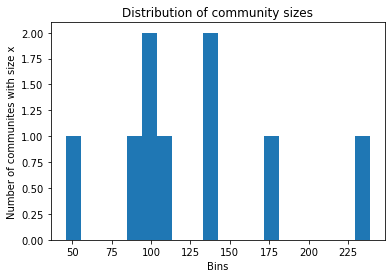

In [44]:
distribution = list(np.bincount(list(partition.values())))
plt.hist(distribution, bins=20)
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Bins')
plt.ylabel('Number of communites with size x')
plt.title('Distribution of community sizes')
plt.show()

This plot shows the distribution of communities sizes. It can be count that we only 
have 9 communities in total, so will work with all of them for the rest of the analysis.

For futher analysis we create a dictionary where each key is the number of the 
community and each value is the list of the nodes which belongs to that community.

In [45]:
communities = defaultdict(list)
for key, val in sorted(partition.items()):
    communities[val].append(key)
communities = {com: members for com, members in communities.items()}

Let's visualize the network, but this time with the communities found. As there are 9 communities, we can reuse the colors from before.

In [46]:
# Again creating the color_map
color_map=[]

# There are enough colors for the communities, so we will reuse them
for node in GU.nodes:
    if node in communities[0]:
        color_map.append("#FF0000")
    elif node in communities[1]:
        color_map.append("#0000FF")
    elif node in communities[2]:
        color_map.append("#8bc34a")
    elif node in communities[3]:
        color_map.append("#b23c17")        
    elif node in communities[4]:
        color_map.append("#ff9800")
    elif node in communities[5]: 
        color_map.append("#ffeb3b")            
    elif node in communities[6]:
        color_map.append("#9c27b0")           
    elif node in communities[7]:
        color_map.append("#e91e63")  
    elif node in communities[8]: 
        color_map.append("black")                                
    else:
        color_map.append("white")

And, the network is visualized using the same force atlas calculation for simplicity.

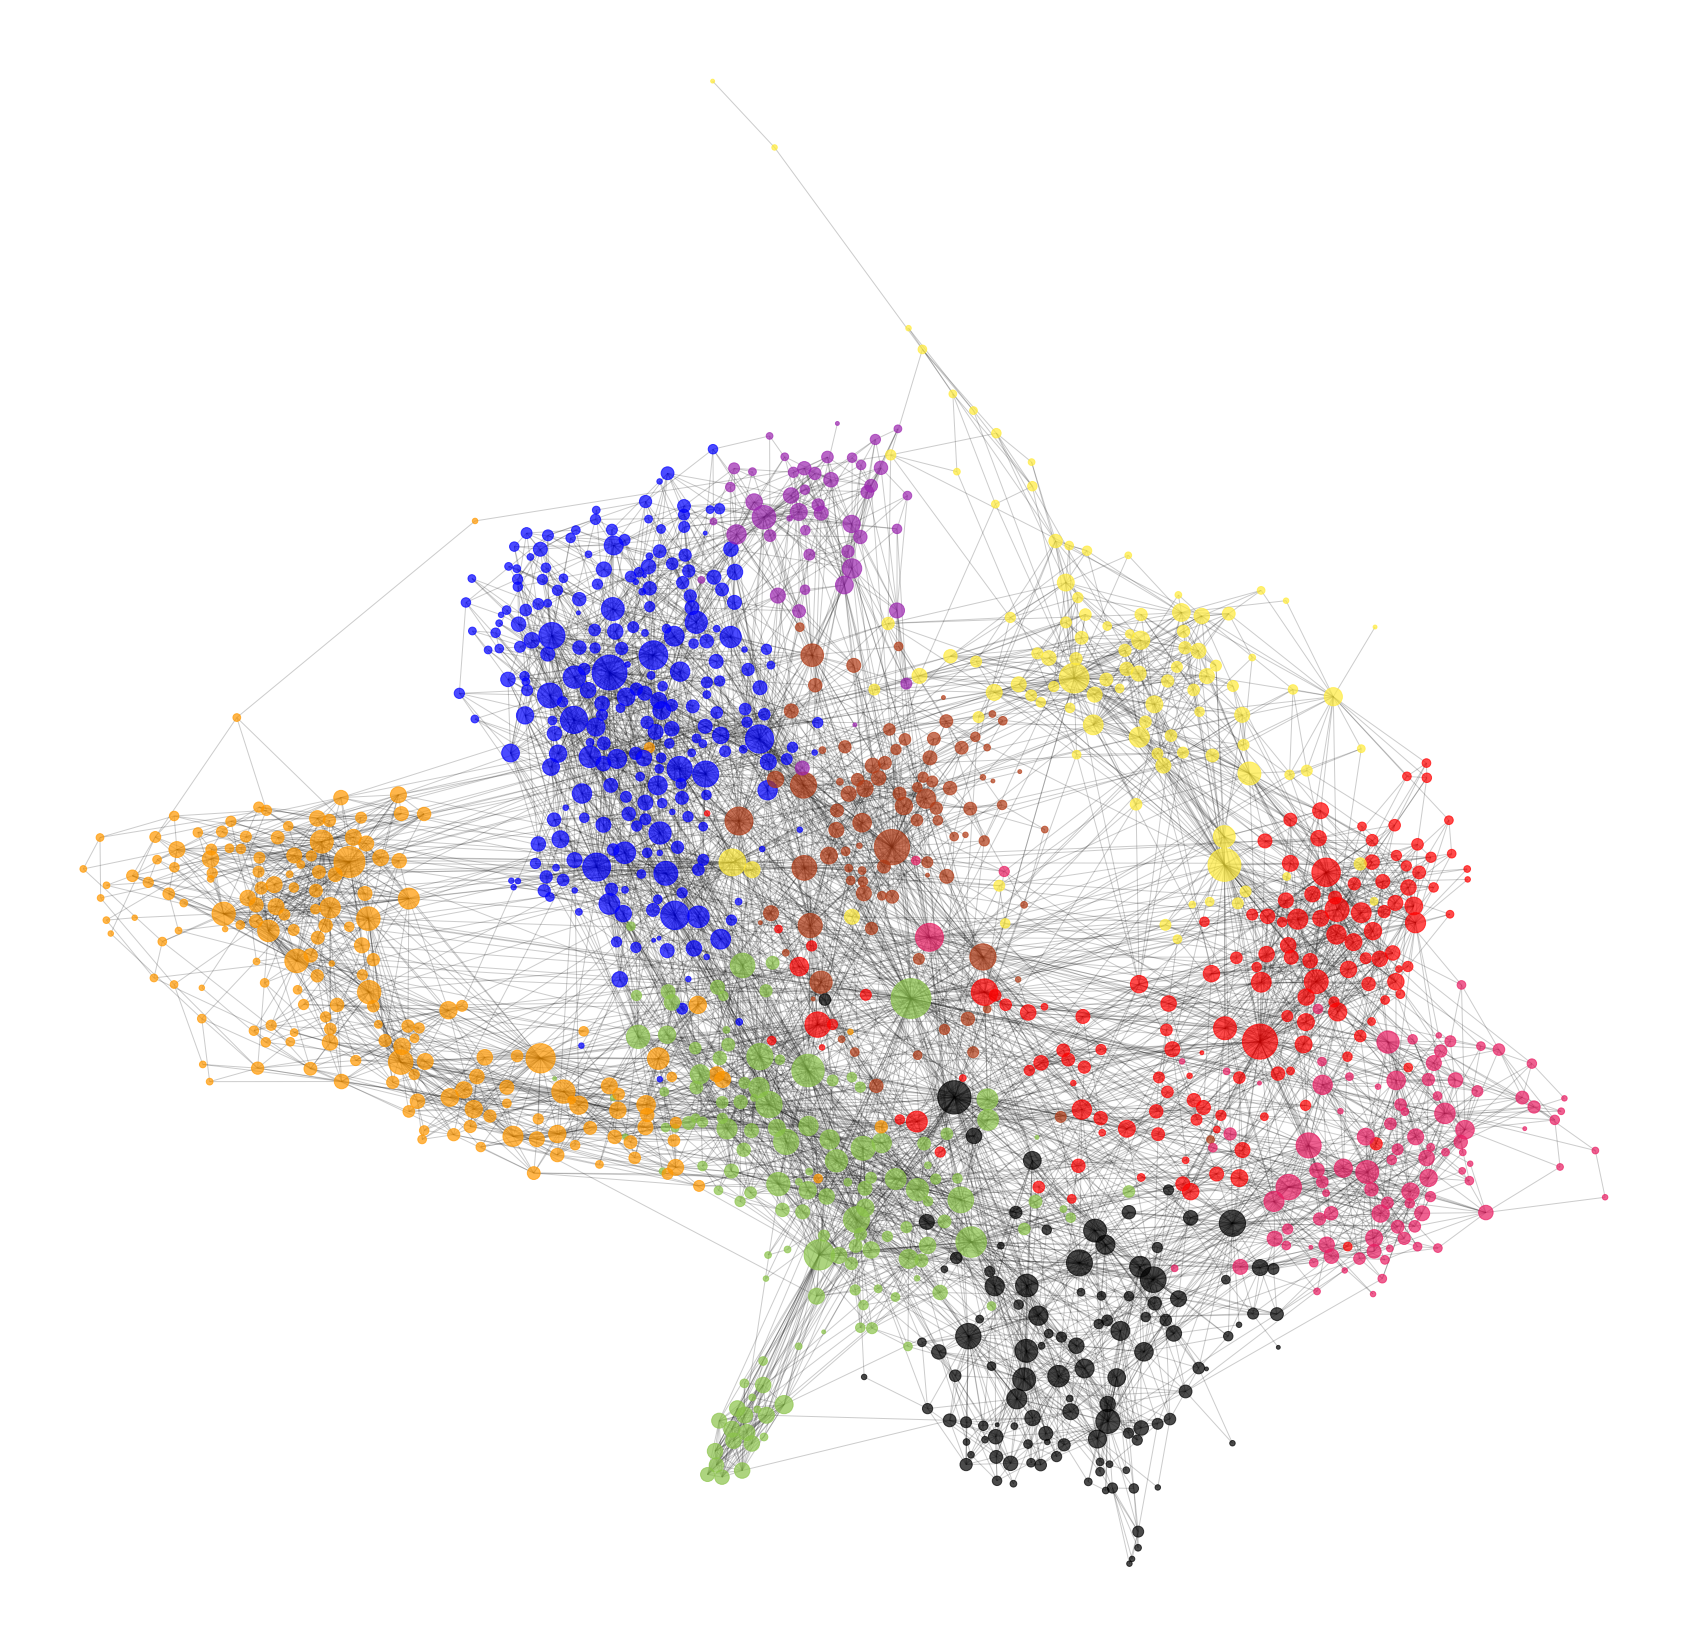

In [47]:
f = plt.figure()
f.set_size_inches(30, 30)
nx.draw_networkx_edges(GU, positions, alpha=0.2)
nx.draw_networkx_nodes(GU, positions, node_size=[d*15 for n, d in GU.degree], node_color=color_map, alpha=0.7)
plt.axis('off')
plt.show()

The network has now been drawn again, but this time the nodes are colored according to community.
This also visualizes how the community extraction went quite well.
Furthermore, comparing this visualization to the previous one showing the system, it can be concluded that the communities are not the same, as the defined systems.
However, the text analysis could still show similarities between central organs within a system and communities, which will be investigated later.

Finally, let's give the communities names based on the three nodes with the longest content in each community. This will be useful later on as well.

In [48]:
community_copy = communities.copy()
for name, community in enumerate(communities.items()):
    sorted_list = sorted([(page, G.nodes[page]['Content length']) for page in communities[name]], key=lambda x: x[1], reverse=True)
    com_name = []
    for page_name, _ in sorted_list[:3]:
        com_name.append(page_name)
    com_name = '-'.join(com_name)
    community_copy[com_name] = community_copy.pop(name)
communities = community_copy.copy()

Let's see what nodes are defining each community.

In [49]:
for com_name in communities:
    print(com_name)

Pelvis-Sacrum-Hip bone
Human tooth-Ear-Trigeminal nerve
Heart-Lung-Thyroid
Human brain-Cerebellum-Spinal cord
Scapula-Hand-Humerus
Human skin-Tendon-Foot
Retina-Human eye-Lens (anatomy)
Clitoris-Vagina-Vulva
Liver-Kidney-Pancreas


The communities now have names that reflect the pages within them that has the highest number of words on their page, instead of just numbers.
The names are not defining the defined systems. They are, however, still closely related.
"Pelvis-Sacrum-Hip bone" are all located in the hip area.
"Human tooth-Ear-Trigeminal nerve" all have to do with the face, as the trigeminal nerve is the nerve responsible for sensation in the face.
"Heart-Lung-Thyroid", where heart and lungs have to do with respiration, the thyroid has to do with hormones, thus this combination is more mysterious.
"Human brain-Cerebellum-Spinal cord" all have to with the brain and central nervous system.
"Scapula-Hand-Humerus" are all connected to the arm (bones).
"Human skin-Tendon-Foot" seems like a more all around community, or maybe it defines the legs, and the skin was just hard to place anywhere.
"Retina-Human eye-Lens (anatomy)" are all about the eye.
"Clitoris-Vagina-Vulva" are all about the female reproductive system, and probably includes the male one as well.
"Liver-Kidney-Pancreas" are organs that are positioned close together in the lower stomach area.

The communities will be examined further later on.

## Text analysis

Moving onto text analysis, the words used on Wikipedia will be investigated further as a whole, but also in communities and systems. First, a general word analysis will be done with the lix readability analysis and sentiment added on.
Then word clouds are made to see what common and unique words (using TF-IDF) in the texts are.

The Gray's Anatomy (41st edition) is used for comparison to all of the Wikipedia pages.

### Functions

Below are the functions used for this section.

**Extracting texts**

As the texts are saved in txt-files, we define helper functions to extract specific texts as strings quickly.

In [50]:
# Input: name of an extracted Wikipedia page as a string
# Output: the text in the txt-file as a string
def get_wikipedia_text(filename: str):
    if '.txt' not in filename:
        filename += '.txt'
    text = io.open('./WikipediaPage/Explain/{}'.format(filename), 'r', encoding='utf-8').read()
    return text

# Input: a list of strings that are the names of an extracted Wikipedia pages
# Output: a string containing all the texts from the given list
def get_wikipedia_texts_from_list(files: list):
    text = '\n\n\n\n'.join([get_wikipedia_text(f) for f in os.listdir('./WikipediaPage/Explain/')])
    return text

# Output: a string containing all the text from the Wikipedia pages
def get_all_wikipedia_texts():
    text = '\n\n\n\n'.join([get_wikipedia_text(f) for f in os.listdir('./WikipediaPage/Explain/')])
    return text


# Input: The number of a chapter from Gray's Anatomy 41e
# Output: The chapter text as a string
def get_chapter(chapter: int):
    text = io.open('./Grays Anatomy/Chapter {}.txt'.format(chapter), 'r', encoding='utf-8').read()
    return text

# Input: The number of a section in Gray's Anatomy 41e as an integer
# Output: The chapter text as a string
def get_section(section: int):
    text = ""
    if section == 1:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(0, 7)])
    elif section == 2:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(7, 15)])
    elif section == 3:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(15, 25)])
    elif section == 4:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(25, 42)])
    elif section == 5:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(42, 45)])
    elif section == 6:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(45, 50)])
    elif section == 7:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(50, 58)])
    elif section == 8:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(58, 77)])
    elif section == 9:
        text = '\n\n\n\n'.join([get_chapter(i+1) for i in range(77, 84)])
    return text


# Output: The entire text of Gray's Anatomy 41e as a string
def get_book():
    book = '\n\n\n\n'.join([get_chapter(i+1) for i in range(0, 84)])
    return book

**Regex patterns**

We define regular expressions here to help us match words that might not contain ASCII characters (this is the `[^\x00-\x7F]` part),
and also to find punctuations that define the end of a sentence. These are by no means perfect, but they have been tested and should find the majority
of desired words.

In [51]:
# Output: a pattern for matching words in a string
def word_pattern():
    return '(?:[A-Za-z]|[^\x00-\x7F])+(?:(?:\-|\')(?:[A-Za-z]|[^\x00-\x7F])+)*(?=.?(?:\s|$))|(?:[a-zA-Z]+\.)+(?= [a-z])|etc\.'

# Output: a pattern for matching the end of sentences in a string.
def punctuation_pattern():
    return '\.(?= [A-Z]|\n|$)'

**Word operations**

Here we define functions that return word lists. The first two are using the above defined regular expressions to find the words and end-of-sentences respectively.
There is also a function that returns a list of stopwords, defined using the help of an nltk corpus.
Additionally, there is a function that finds stopwords, and one that removes them in a list of words.
Lastly, there is a function that can return a list of words that a greater than a given length and a list of words.

In [52]:
# Input: a text as a string
# Output: a list of word tokens in the text (all lowercase)
def get_words(text: str):
    words = re.findall(word_pattern(), text)
    words = [x.lower() for x in words]
    return words

# Input: a text as a string
# Output: a list of punctuations that define the end of a sentence
def get_punctuations(text: str):
    punctuations = re.findall(punctuation_pattern(), text)
    return punctuations

# Output: A list of registered stopwords
def stopword_list():
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords += ['et', 'al', 'also', 'may']
    return stopwords

# Input: a list of word tokens
# Output: the list of word tokens with only stopwords
def get_stopwords(words: list):
    stopwords = stopword_list()
    non_content = [word for word in words if word.lower() in stopwords]
    return non_content

# Input: a list of word tokens
# Output: the list of word tokens without any stopwords
def remove_stopwords(words: list):
    stopwords = stopword_list()
    content = [word for word in words if word.lower() not in stopwords]
    return content

# Input: a list of word tokens, a number indicating the word length
# Output: a list of words with at least the indicated word length
def long_words(words: list, length: int):
    return [word for word in words if len(word) >= length]

**NLTK and helper functions**

In [53]:
# Input: a count of occurences, a count of total occurences
# Output: the percentage of occurance
def percentage(count: int, total: int):
    return round(100 * count / total, 2)

**Readability and sentiment**

In [54]:
# Input: a text as a string
# Output: a lix readability score (higher means more difficult)
def readability_test(text: str):
    # Get the count of words.
    A = get_words(text)
    # Get the count of periods (that are not part of an abbreviation).
    B = get_punctuations(text)
    # Get the count of words longer than 6 letters. Re-use the result from A.
    C = [s for s in A if len(s) > 6]
    lix = (len(A) / len(B)) + ((len(C) * 100) / len(A))
    return lix

# Input: a list of words
# Output: a sentiment score (higher means happier)
def sentiment_test(words: list):
    url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
    dfs = pd.read_csv(url, sep='\t', header=2)
    return pd.DataFrame(words, columns=['word']).merge(dfs, on = 'word').happiness_average.mean()

**Example analysis**

In [55]:
def example_analysis(title: str, text: str):
    print(f'### {title.upper()} ###')
    print('\n## WORDS ##')
    words = get_words(text)
    print(f'{len(words)} words in the book.')
    sentences = get_punctuations(text)
    print(f'{len(sentences)} sentences in the book.')
    avg_words = len(words)/len(sentences)
    print(f'{round(avg_words,2)} words on average pr. sentence.')
    unique_words = set(words)
    print(f'{len(unique_words)} unique words in the book.')
    diversity = percentage(len(unique_words),len(words))
    print(f'{diversity:.2f}% of the book is written with unique words.')
    print('\n## LONG WORDS ##')
    length_10 = long_words(words, 10)
    print(f'{len(length_10)} words are 10 letters or longer ({percentage(len(length_10),len(words)):.2f}% of total text).')
    length_15 = long_words(words, 15)
    print(f'{len(length_15)} words are 15 letters or longer ({percentage(len(length_15),len(words)):.2f}% of total text).')
    length_20 = long_words(words, 20)
    print(f'{len(length_20)} words are 20 letters or longer ({percentage(len(length_20),len(words)):.2f}% of total text).')
    print('\n## STOPWORDS ##')
    stopwords = get_stopwords(words)
    print(f'{len(stopwords)} stopwords in the book.')
    percent_stopwords = percentage(len(stopwords),len(words))
    print(f'{percent_stopwords:.2f}% of the book is stopwords.')
    print('\n## READABILITY ##')
    lix = readability_test(text)
    print(f'{title} has a Lix score of {round(lix)}.')
    print('\n## SENTIMENT ##')
    sentiment = sentiment_test(words)
    print(f'{title} has a sentiment average of {sentiment:.2f}.')

**Word clouds**

From this point on, the next functions are used to create wordclouds for the groups defined, so for
the communities we will have 9 groups (9 wordclouds), and for the systems another 9 groups (9 workclouds).<br> 

1. Functions to get the list of words of each group (e.g. for each community or each system).

In [56]:
# This function get all the tokens from a list of txt files.The tokens are lowercase and lemmatize.
def tokenize_pages( txt_files: list):
    tokens = wordlists.words(txt_files)
    lower_tokens = [w.lower() for w in tokens]
    content = [w for w in lower_tokens if w not in stopwords]
    wnl = nltk.WordNetLemmatizer()
    words = [wnl.lemmatize(t) for t in content]
    return words

# Function to get the txt files from the dataframe using the node name
def get_group_files_df(group: list, df):
    files_in_group = []
    for name in group:
        txt_file = df.loc[df['WikiLink'] == name, 'Name'].iloc[0] + '.txt'
        files_in_group.append(txt_file) 
    return files_in_group

# Function to extract the tokens from all the text files of a group
def get_group_wordlist(txt_files:list , getTxtFromdf: bool):
    if getTxtFromdf:
        files_in_group = get_group_files_df(txt_files, df)    # get txt files from dataframe
    else:
        files_in_group = txt_files
    words_in_group = tokenize_pages(files_in_group) # tokenize each page
    return words_in_group       

# Function to store in a dict the list of words from each group
def get_groups_wordlists(groups: dict, getTxtFromdf:bool):
    return {group: get_group_wordlist( txt_files, getTxtFromdf ) for group, txt_files in groups.items()}

2. Functions to get a dictionary with the TF values for the words in each group.

In [57]:
def get_fdists_groups( wordlists_all_groups: dict ):
    return {group: nltk.FreqDist(word_list) for group, word_list in wordlists_all_groups.items()}

def get_most_common_groups( fdists_all_groups: dict):
    return {group: fdist.most_common() for group, fdist in fdists_all_groups.items()}

# Function to convert the list of tuples ('word': frequency) of each group to dictionaries
def getTF_tupleToDict( tuple_to_convert:tuple):
    tf_dict = {key: {} for key in tuple_to_convert.keys()}  # get group names
    for group, bigram_list in tuple_to_convert.items():
        tf_dict[group] = dict(bigram_list)
    return tf_dict        

3. Functions to get a dictionary with IDF weight values for the words in each group.


In [58]:
def get_idf(TF_dict: dict, all_tf_lists: list):
    count = 0
    N = len(all_tf_lists)
    IDF_dict = {}
    
    # Iterate through the TF dictionary 
    for word in TF_dict.keys():
        # Check for each word if it's in any of the word-lists among communities
        for i in range(N):
            if word in all_tf_lists[i].keys():
                count += 1
        # Calculate weight for word
        idf = math.log10( N/(count) )
        # Save it to the final dictionary
        IDF_dict[word] = idf   
        count = 0
    return IDF_dict

def get_idfs_groups(TFs_dict_groups: dict):
    tfs_list_groups = list(TFs_dict_groups.values())
    # Get weight for each word in each group
    return {group: get_idf(tf_dict, tfs_list_groups) for group, tf_dict in TFs_dict_groups.items()}

4. Functions to get a dictionary with TF-IDF values for the words in each group.

In [59]:
# Function to get the TF-IDF values for each word in the given group
# Multiply the count for each word by the weight from the IDF dict for the given group
def get_TF_IDF(TF_dict, IDF_dict):
    TF_IDF_dict = {}
    for k in TF_dict.keys():
        TF_IDF_dict[k] = round(TF_dict[k] * IDF_dict[k]) # TF_IDF dictionary
    return TF_IDF_dict   

# Get the weighted TF dict (TF_IDF) for all the groups
def get_TF_IDF_groups(groupKeys, TF_dict, IDF_dict):
    return {group: get_TF_IDF(TF_dict[group], IDF_dict[group]) for group in groupKeys}            

5. Fucntions to create the wordclouds with the TF or TF-IDF dictionaries

In [60]:
# Create a single string for each group to be able to display each wordcloud
def create_string_to_cloud(TF_IDF_dict):
    # Repeat each word and a space "count" times and save it to a list
    list_to_cloud = [(word + " ") * count for word, count in TF_IDF_dict.items()]
    return ' '.join(list_to_cloud)   # Join the created lists with spaces

# Construct wordclouds with the help of the WordCloud package for each group
def create_wordclouds(TF_IDF_dicts):
    return {group: WordCloud(background_color="black", collocations=False).generate(create_string_to_cloud(tf_idf_dict)) for group, tf_idf_dict in TF_IDF_dicts.items()}

# Functin to display the wordcloud and set the position with subplot
def draw_wordclouds(wordclouds):
    for key in wordclouds.keys():
        f = plt.figure()
        f.set_size_inches(7, 4)
        plt.rcParams['figure.figsize'] = [20, 20]
        plt.title(key, fontsize=20) 
        plt.imshow(wordclouds[key], interpolation='bilinear')
        plt.axis("off")
        plt.show()     

6. Functions to run the above functions to get the TF and the TF-IDF values followed by
drawing the wordclouds.
This functions will be the ones used to create the wordclouds in the following points.
The input has to be a dictionary where each key is the name of a group and each value is
the list of txt files from which the wordclouds are gonna be created.

In [61]:
def show_wordclouds_tf(word_lists_dict: dict):
    # Create word frequency list for each group
    fdists = get_fdists_groups(word_lists_dict)
    # Create a sorted list starting with the most common words for each community
    counts = get_most_common_groups(fdists)
    # Get TF for the wordlists of each community
    TF_dicts = getTF_tupleToDict( counts )
    # Create the wordclouds with the tf values
    wordclouds = create_wordclouds(TF_dicts)
    # Draw all the wordclouds
    draw_wordclouds(wordclouds)

In [62]:
def show_wordclouds_tf_idf(word_lists_dict: dict):
    # Create word frequency list for each group
    fdists = get_fdists_groups(word_lists_dict)
    # Create a sorted list starting with the most common words for each community
    counts = get_most_common_groups(fdists)
    # Get TF for the wordlists of each community
    TF_dicts = getTF_tupleToDict( counts )
    # Get IDF for the wordlists of each community
    IDF_dicts = get_idfs_groups(TF_dicts)
    # Get keys of the groups
    groupKeys = TF_dicts.keys()
    # Calculate tf-idf lists
    TF_IDF_dicts = get_TF_IDF_groups(groupKeys, TF_dicts, IDF_dicts)
    # Create the wordclouds with the tf-idf values
    wordclouds = create_wordclouds(TF_IDF_dicts)
    # Draw all the wordclouds
    draw_wordclouds(wordclouds)

### Analysing texts

For the text analysis, it was decided that the Wikipedia pages do yield interesting results on its own, but comparing it to a medical anatomy book, might yield better results, and could potentially highlight differences between Wikipedia and textbooks.

There are different ways to analyse the texts, as up until now, there are individual pages, systems, communites, chapters, sections and entire collections, so for this part, we will simply show an example analysis, but further results can be found on the website.

Here we'll take a look at the entire Wikipedia text together, and the entire book together.

In [63]:
example_analysis("Wikipedia pages", get_all_wikipedia_texts())

### WIKIPEDIA PAGES ###

## WORDS ##
636444 words in the book.
24705 sentences in the book.
25.76 words on average pr. sentence.
23131 unique words in the book.
3.63% of the book is written with unique words.

## LONG WORDS ##
53634 words are 10 letters or longer (8.43% of total text).
3434 words are 15 letters or longer (0.54% of total text).
191 words are 20 letters or longer (0.03% of total text).

## STOPWORDS ##
270654 stopwords in the book.
42.53% of the book is stopwords.

## READABILITY ##
Wikipedia pages has a Lix score of 56.

## SENTIMENT ##
Wikipedia pages has a sentiment average of 5.25.


In [64]:
example_analysis("Gray's Anatomy", get_book())

### GRAY'S ANATOMY ###

## WORDS ##
1084200 words in the book.
46554 sentences in the book.
23.29 words on average pr. sentence.
24552 unique words in the book.
2.26% of the book is written with unique words.

## LONG WORDS ##
109598 words are 10 letters or longer (10.11% of total text).
8930 words are 15 letters or longer (0.82% of total text).
299 words are 20 letters or longer (0.03% of total text).

## STOPWORDS ##
456496 stopwords in the book.
42.10% of the book is stopwords.

## READABILITY ##
Gray's Anatomy has a Lix score of 56.

## SENTIMENT ##
Gray's Anatomy has a sentiment average of 5.24.


From studying the words used on Wikipedia and those in textbook,
it can be seen that the sentence-lengths on Wikipedia averages a little higher than in the textbook.
However, the length of the words in the book seems to be longer in general, which explains how the Lix score ends up the same for both texts.
The amount of stopwords in both texts are quite similar, but it could be that the average English text consists of about 40% stopwords.
The sentiment is shown to be quite neutral in both texts.

### Most common words and word clouds

Now that we know a little bit of information about the texts. Let's first try to create word clouds displaying the most common words for both the Wikipedia pages and the textbook.

**Wikipedia pages (Term Frecuency)**

We call the function that look for the most common words in txt files and that 
draw the wordcloud. As input we define a dictionary where its value is a list 
of all the wikipedia txt files.

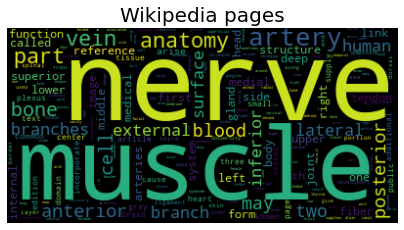

In [65]:
show_wordclouds_tf( {'Wikipedia pages': get_words(get_all_wikipedia_texts())} )

Here it can be seen that the frequent words on Wikipedia are mostly anotomical, but there are also some "Wikipedia words" that have snuck in,
e.g. "image", "text", and "page".

**Gray's Anatomy textbook (Term Frecuency)**

We repeat the same operation with the textbook.

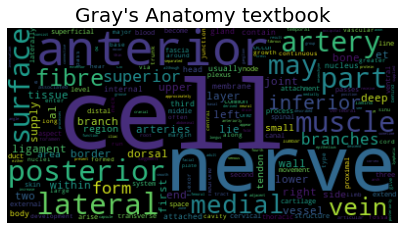

In [66]:
show_wordclouds_tf( {"Gray's Anatomy textbook": get_words(get_book())} )

The textbook also contains mainly anatomical words, but a few common words that do not mean much for the text, and was not filtered out as stopwords,
are still present, e.g. "may" and "usually".

**Wikipedia pages and Gray's Anatomy textbook (Term Frecuency - Inverse Document Frequency)**

Now we want to go one step further, and for that we will create the wordclouds again but
this time using Inverse Document Frequency.<br>
First we define the dictionary for the wikipedia pages and the book, for their
value we call the corresponding functions to get the txt files from each one as before.

More information together with the equations to apply TF-IDF can be found [here](https://en.wikipedia.org/wiki/Tf–idf).

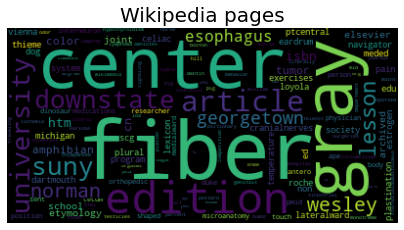

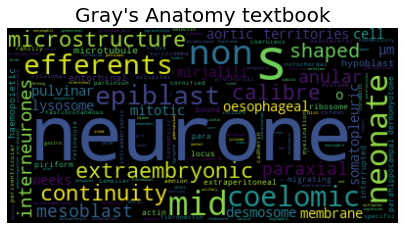

In [67]:
wikipedia_book = { 'Wikipedia pages': get_words(get_all_wikipedia_texts()), "Gray's Anatomy textbook": get_words(get_book())}
show_wordclouds_tf_idf(wikipedia_book)

Now that the unique words of both texts have been filtered, the results are quite interesting. It can be seen that many of the words are still medical terms. "fiber" is, for example, mentioned more on Wikipedia than in the textbook. This is because the textbook usually referes to "fibres" a lot more. The opposite can be said about neurone, which Wikipedia does not really use, but the textbook does.
Another example is that "cell" is a common word in both texts, but is mentioned enough in the textbook to still make it through the TF-IDF filtering.
Besides the medical terms, present are also a lot of names, places, and other words that are used in referencing on Wikipedia, where the same cannot quite be found in the textbook.

**Wikipedia communities**

To study the communites, TF-IDF will be used to see which common words within the communities makes the community unique to the others. It is also interesting to see if the communities can be compared to the defined systems, or if they are completely different.

For the communities we use the nltk library to create a corpus which contains the Wikipedia pages,
then we get the list of token of each community and finally we get the TF-IDF values
for all the words in each community to draw the wordclouds

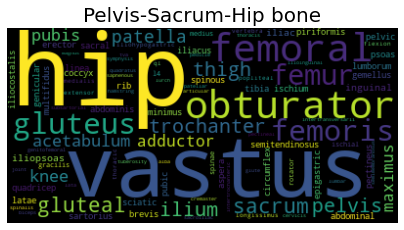

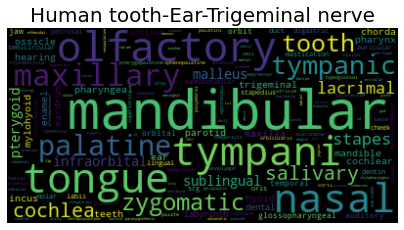

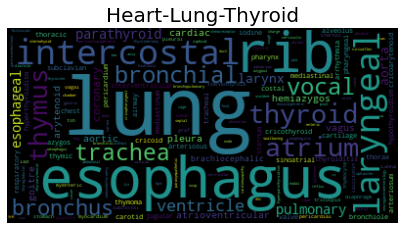

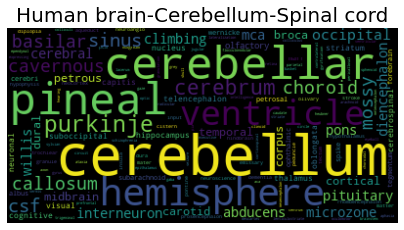

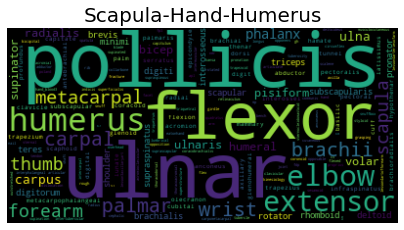

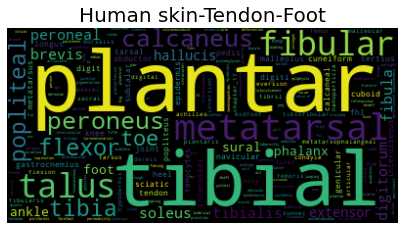

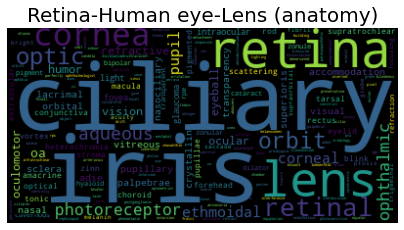

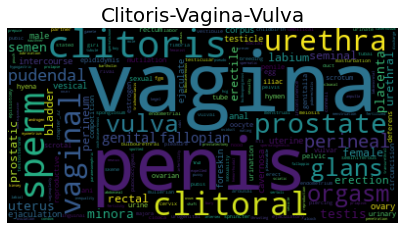

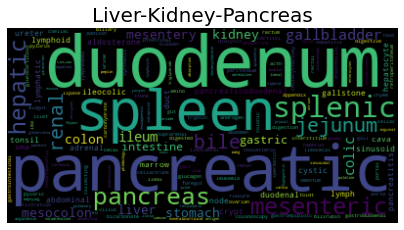

In [68]:
# Create corpus
corpus_root = "./WikipediaPage/Explain"
wordlists = PlaintextCorpusReader(corpus_root, '.*')

# Load stopwords from nltk library
stopwords = nltk.corpus.stopwords.words('english')
               
# Boolean to extract the wikiLink from the dataframe using the node name                 
getTxtFromdf = True
# Get the tokens of each community
com_word_lists = get_groups_wordlists(communities, getTxtFromdf)

# Get TF-IDF and draw wordclouds
show_wordclouds_tf_idf(com_word_lists)

With the most unique words in each community, it is possible to get better understanding of what each community contains, and if the title reflects the content.

For the "Pelvis-Sacrum-Hip bone" community, it is found that this community is in fact centered around the hip, pelvis, thigh area with words like: "vastus", "femur" and "gluteal".

Next, the "Human tooth-Ear-Trigeminal nerve" community again supports that this community is centered around the face and senses (except the eyes and brain), with common words like: "tongue", "olfactory" (sense of smell) and "mandibular" (lower jaw).

The common words in "Heart-Lung-Thyroid" community also shows that it has a lot to do with breathing (with lung being dominant), and the chest area with words like: "esophagus", "intercostal", "bronchus" and "rib".

The "Human brain-Cerebellum-Spinal cord" is a bit harder to interpret. It is still thought that this community is about the brain and most connected nervous system, but since a lot of nerves are spread around the communities, left are words like: "pineal", "cerebellar" and "willis", which still supports this claim. Surprisingly, the word "ventricle" is dominant in this community, but it is related to the heart.

The "Scapula-Hand-Humerus" community was thought to be about the arm or shoulder, and this is supported by the word cloud with common words like: "ulnar", "pollicis" and "elbow". Most of the presented words seem to be in the arm or shoulder somewhere.

Next up is the "Human skin-Tendon-Foot", which was thought to be a leg, and that "human skin" just happens to be here, as it was hard to place in a certain community. Words like: "tibial", "plantar" and "metatarsal" supports that the community is about the leg and foot.

The "Retina-Human eye-Lens (anatomy)" community the words are quite clearly all about the eye, e.g. "iris", "ciliary", "optic".

The "Clitoris-Vagina-Vulva" community has nicely collected everything about the male and female reproductive systems, and it is quite clear and cut.

Lastly, the "Liver-Kidney-Pancreas" community is also showing to be about the pelvis area, and maybe more precisely, the lower end of the digestive system.

This means that it can be concluded that the communities (and thus Wikipedia links) are mostly based on the organs placement in the body more than the anatomical systems that they belong to.

**Wikipedia systems**

We repeat the same operations with the systems. So first we get the names of the 
systems. With them we create the dictionary where the keys are the name of the systems
and the values are txt files of that system.

We will use the following functions to get the dictionary with the txt files.

In [69]:
def get_nodes_system(system_name, systems_dict):
    return [k for k,v in systems_dict.items() if v == system_name]

def get_system_groups(unique_systems):
    return {system: get_nodes_system(system, systems_dict) for system in unique_systems}  

And now we draw the wordcloud of the systems.

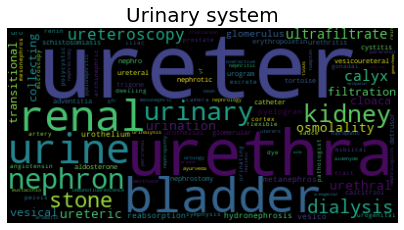

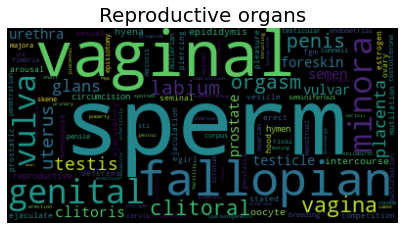

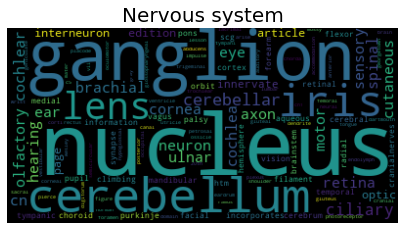

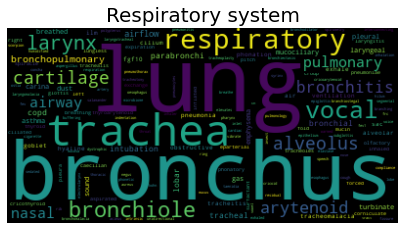

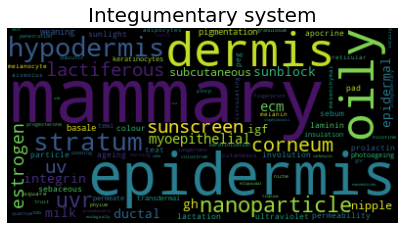

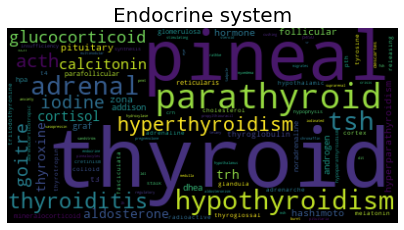

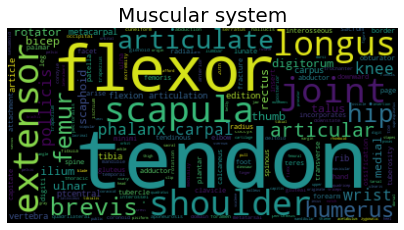

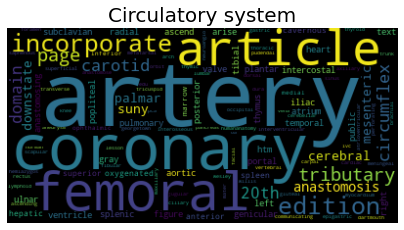

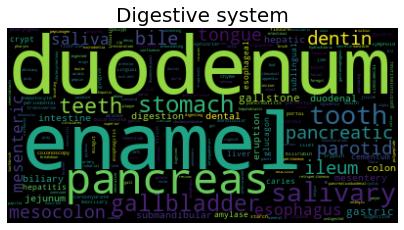

In [70]:
# Get the systems names
systems_dict = nx.get_node_attributes(GU,'System')
unique_systems = set( s for s in systems_dict.values())

# Create dict with the systems names
systems_dict_grouped = get_system_groups(unique_systems)

# Boolean to extract the wikiLink from the dataframe using the node name                 
getTxtFromdf = True
# Get the tokens of all the txts in each system, calculate tf-idf and draw wordclouds
systems_wordlists = get_groups_wordlists(systems_dict_grouped, getTxtFromdf)
show_wordclouds_tf_idf(systems_wordlists)

It is already known how the systems are different, and the resulting words in each word cloud is quite predictable, but it is still interesting to compare the systems and communities.

It can be seen in the above word clouds that some common anatomcial terms like "artery" in the circulatory system, "nucleus" in the nervous system, and "tendon" in the muscular system are now more present in the word clouds, meaning that these words were more spread out between the communities before, again supporting the claim that the communites mostly do not describe the systems.

Another interesting result is that there were 9 communities and 9 systems, which also makes them easier to compare.

### In-depth sentiment analysis

Lastly, we want to study if the wikipedia pages of the human body have some kind of sentiment,
We suppose that as the topic is "anatomy" then the wikipages should be even more neutral 
than other wikipages about others topics.


**Wikipedia pages**

We will use the LabMT wordlist data, from 
[Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). 
We expect that as specific words of the anatomy are not going to be present in the 
dataset, we can get some positiveness or negativeness, as for example words like 
"heart" are positive in the list. 
We won't analyse the textbook as it is too specific in the matter.<br>

We start by reading the data and defining the funcion to analyse the sentiment.

In [71]:
url = 'https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0026752.s001&type=supplementary'
dfs = pd.read_csv(url, sep='\t', header=2)

In [72]:
def sentiment(tokens):
    return pd.DataFrame(tokens, columns=['word']).merge(dfs, on = 'word').happiness_average.mean()

We iterage over the nodes in our network to tokenize each page and to calculate the sentiment of every page. 
We add the sentiment as a new nodal property.

In [73]:
for node in GU.nodes:
    # tokenize each page
    txt_file = df.loc[df['WikiLink'] == node, 'Name'].iloc[0] + '.txt'
    tokens = wordlists.words(txt_file)
    lower_tokens = [w.lower() for w in tokens]
    content = [w for w in lower_tokens if w not in stopwords]
    wnl = nltk.WordNetLemmatizer()
    words = [wnl.lemmatize(t) for t in content]
    average_sentiment = sentiment(tokens)
    # calculate sentiment
    GU.nodes[node]['Sentiment'] = average_sentiment    

We get a dict with the nodes and its corresponding average sentiment.

In [74]:
dict_nodes_sentiment = nx.get_node_attributes(GU,'Sentiment')

Now we plot an histogram of all the sentiment averages of our network.

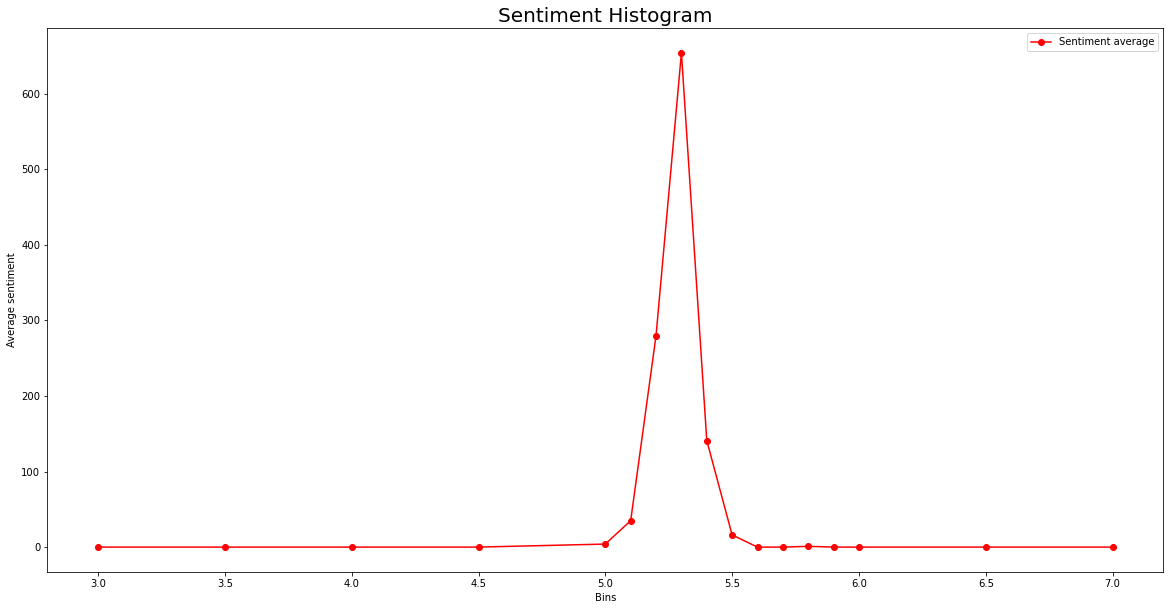

In [75]:
# Get all the sentiment values
sentiment_values = [ v for k,v in dict_nodes_sentiment.items()]

# Plot histogram
v = [3, 3.5, 4, 4.5, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.5, 7]
histog, bins = np.histogram(sentiment_values, bins = v)

plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(bins, np.insert(histog, 0, histog[0]), 'ro-', label='Sentiment average')
plt.xlabel('Bins')
plt.ylabel('Average sentiment')
plt.title('Sentiment Histogram', fontsize=20) 
plt.legend()

From the plot it can easily be seen that the wikipedias pages are neutral, this is
due to the neutral tone wikipedia uses and also because the topic of these pages
is about "anatomy". So even though our vocabulary is not in the list we stil get a 
neutral tone. In this way, even though "heart" can have a positive score, the 
average sentiment for the overall page is neutral.

Finally, we will see if there is any kind of relationship between the happiest
and sadness wikipedia pages. For that, we first sort our dictionary with the 
sentiment average and then we get the first 10 and the last 10 items in it.

In [76]:
# List with the characters sorted from happiest to saddest 
sorted_sentiment = sorted(dict_nodes_sentiment.items(), key=lambda x: x[1], reverse=True)
print(f"The 10 characters with happiest pages are:")
for bigram in sorted_sentiment[:10]:
    print(f" - {bigram[0]} with a sentiment of {format(bigram[1], '.3f')}")
print(f"\nAnd the 10 characters with saddest pages are:")
for bigram in sorted_sentiment[-10:]:
    print(f" - {bigram[0]} with a sentiment of {format(bigram[1], '.3f')}")

The 10 characters with happiest pages are:
 - Temporoparietalis muscle with a sentiment of 5.702
 - Superior rectus muscle with a sentiment of 5.477
 - Transversospinales with a sentiment of 5.473
 - Uterine veins with a sentiment of 5.465
 - Deep cerebral veins with a sentiment of 5.446
 - Anterior intercostal veins with a sentiment of 5.440
 - Zygomaticus major muscle with a sentiment of 5.434
 - Risorius with a sentiment of 5.432
 - Lateral rotator group with a sentiment of 5.424
 - Dorsal digital arteries of hand with a sentiment of 5.424

And the 10 characters with saddest pages are:
 - Left colic vein with a sentiment of 5.031
 - Ileocolic vein with a sentiment of 5.029
 - Inferior cardiac nerve with a sentiment of 5.019
 - Dorsal scapular vein with a sentiment of 5.016
 - Dorsal lingual veins with a sentiment of 5.011
 - Gonadal vein with a sentiment of 5.000
 - Appendicular vein with a sentiment of 4.993
 - Cavernous nerves with a sentiment of 4.987
 - Dorsal metatarsal veins w

Inspecting the happiest and saddest pages we find that both are formed by
short pages, where there is only a summary with some details, and sometimes somes
lines of explanation. So as shorter pages can be both positive or negative 
we could conclude that shortert pages are more likely to be the happiest or saddest.
But we are going to try to verify this
in the next point.

**Correlation between content length and sentiment average**

Let's check the correlation between content length (number of words) and the sentiment average.

We want to see if the length of a page is correlated with its the possitiveness or sadness.
For this we use the pearson correlation as in previous points.

In [77]:
lengths = [GU.nodes[node]['Content length'] for node in GU.nodes]
sentiments = [GU.nodes[node]['Sentiment'] for node in GU.nodes]
corr_ls, _ = pearsonr(lengths, sentiments)
print('Pearsons correlation: %.3f' % corr_ls)

Pearsons correlation: 0.109


We have got a low correlation, so we can conclude that there is no linear correlation 
between the content lenght and the average sentiment of a page.


## 4. Discussion

For this section, the project assignment will be reviewed as a whole.

The results were found to be quite interesting, as the Wikipedia pages actually had links to other Wikipedia pages of organs that were close by rather than that of Wikipedia pages within an anatomical system, e.g. the respiratory system, or muscular system.

Furthermore it was interesting to see, how the pages seemed to be on par with that of a anatomical textbook, as very few differences were found between readability and the words used.

It is hard to say if there were more interesting analyses that could have been made on the network or text to yield meaningful results. It should however be taken into consideration that the dataset that was used for the project, might not have all relevant Wikipedia pages that are describing the body, and maybe some of the pages that were included, should not have been included. Though, it did look like, when comparing to the textbook, that most of the body was represented within the dataset.

Some ideas for further analysis, could be to find a way to create a network over the textbook that was used, or to find data that are describing anatomy of animals and compare to humans. Also, a sentiment dataset, like the one used, could have been custom made to ensure that organs (and other common words) were in the dataset, to create more colorful results in that analysis.

## 5. Contributions

This section indicates who contributed the most to a certain relevant section.

### Nóra Murakozi

Basic stats, creation of the network, Connectivity, Drawing the network, Centrality, Content-length analysis

### Christian Pilgaard

Motivation, Creation of dataset, Extracting text from the textbook, General text analysis, Discussion

### Angélica Suárez

Community extraction, TF-IDF, Word clouds, Sentiment analysis